# Lesson 1 Pratice Notebook
This notebook contains pratice code generated while going through Lesson 1 of FastAI course.
### Intro the dataset
* The Dog vs Cats dataset consists of lebelled imaged of dogs and cats.
* Total number of training examples, $m_{train}$ = 25,000
* Total number of test examples, $m_{test}$ = 12,5000.
* As of 2013, best performing machine learning algorithms had about 80% accuracy.

In order to get set up, let's configure this notebook. This will make sure that external modules are automatically reloaded if any changes are made to the underlying code, and that plotting and fastai functionality is available to us.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Let's also make sure that NVidia GPU is set up and ready to use.

In [5]:
print(torch.cuda.is_available())
# this is optional
print(torch.backends.cudnn.enabled)

True
True


Perfect! Finally, let's set some global variables, such as the path to the dataset files and the image size (more details on this later). 

In [6]:
PATH = "data/dogscats/"
sz = 224

### A note on dataset organization for ML/DL
One of the major takeaways from this lesson was that typically the datasets for ML/DL are split as follows:

* Train: This is our training dataset.

* Valid: This is validation dataset, used for hyperparamter optimization.

* Test: This the final test set unseen by the model.

One can also create a parallel version of the above for just setting things up, just to make sure that everything is working fine. We can call this sample dataset.

## A quick look at the dataset
Let's take a look at the dataset and also see if our directory structure is organized properly.

In [7]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [8]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [9]:
files = os.listdir(f'{PATH}valid/cats')
files[:10]

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg',
 'cat.7585.jpg',
 'cat.3808.jpg',
 'cat.3052.jpg',
 'cat.1616.jpg',
 'cat.7850.jpg']

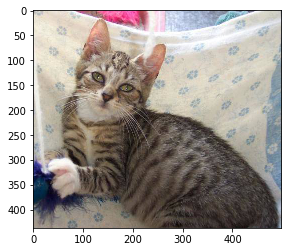

In [10]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [11]:
img.shape

(437, 499, 3)

In [12]:
img[:4, :4]

<class 'numpy.ndarray'>


array([[[211, 211, 219],
        [210, 211, 216],
        [208, 207, 213],
        [202, 201, 206]],

       [[200, 201, 206],
        [199, 198, 204],
        [196, 195, 200],
        [193, 192, 197]],

       [[193, 192, 197],
        [189, 188, 193],
        [184, 183, 188],
        [185, 185, 187]],

       [[197, 195, 198],
        [189, 187, 190],
        [181, 179, 180],
        [183, 181, 182]]], dtype=uint8)

## First Model
Main features:
* A pre-trained model, trained on ImageNet
* A convolutional neural network, called resnet 34

Let's train!

In [12]:
arch = resnet34
# load in data
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
# create model
learn = ConvLearner.pretrained(arch, data, precompute=True)

**A note on pre-computed activations**
Based on a quick look around on what does it mean to have precomputer activations for your neural network, I think that this has to do with how transfer learning is basically done. We have trained model, especially a model from a large dataset (such as ImageNet). We then 'freeze' let's say N layers, which means that we no longer wish to train them anymore and would like to keep there parameters as such. We can then output acttivations form the last frozen laeyer and save them as part of the model. We can tne add oen more more new layers that are trined on a new dataset.

In [33]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
data.classes

['cats', 'dogs']

In [15]:
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.051083   0.030362   0.987305  
    1      0.048798   0.025642   0.991211                     



[0.025642162, 0.9912109375]

Now that the we have fit the model, we can see that it's accuracy (which I assume is based on cross-validation) is ~99%. Let's take a look at some example of predictions.

In [17]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [18]:
log_preds[:10]

array([[ -0.00004, -10.13922],
       [ -0.00131,  -6.63607],
       [ -0.00043,  -7.74885],
       [ -0.00034,  -7.99396],
       [ -0.00016,  -8.70995],
       [ -0.00034,  -7.98523],
       [ -0.00009,  -9.29825],
       [ -0.00006,  -9.70384],
       [ -0.00104,  -6.87058],
       [ -0.00019,  -8.59361]], dtype=float32)

In [22]:
# let's get prediction, expressed as 0 or 1 for if the image is of a cat or a dog respectively. 
preds = np.argmax(log_preds, axis=1)
# let's also convert log values into probabilities
probs = np.exp(log_preds[:, 1])
print(probs[:10])

[0.00004 0.00131 0.00043 0.00034 0.00016 0.00034 0.00009 0.00006 0.00104 0.00019]


In order to facilitate looking at different images from the dataset and corresponding predictions, let's create some utility functions.


In [23]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)

In [24]:
def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)

In [25]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [26]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [27]:
def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

In [28]:
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))


Correct


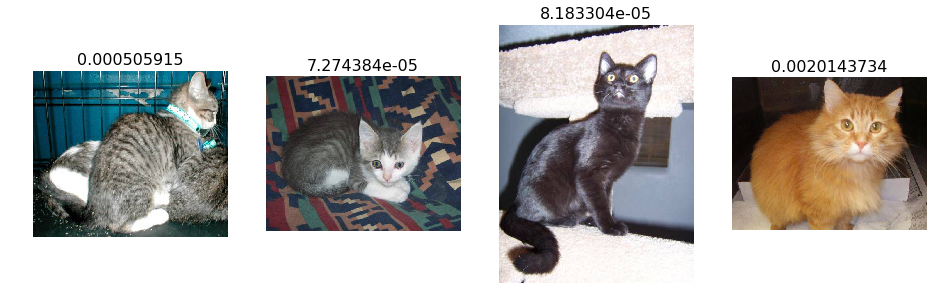

In [30]:
plot_val_with_title(rand_by_correct(True), "Correct")

Incorrect


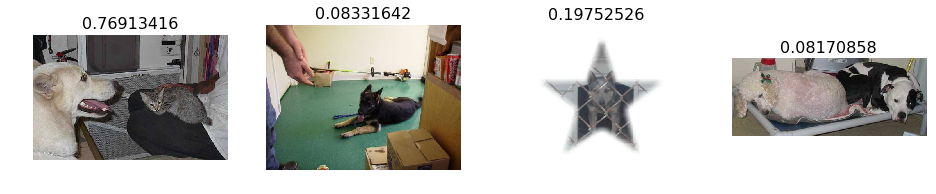

In [31]:
plot_val_with_title(rand_by_correct(False), "Incorrect")

## Choosing a learning rate

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [33]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▎ | 301/360 [00:05<00:01, 53.74it/s, loss=0.41] 


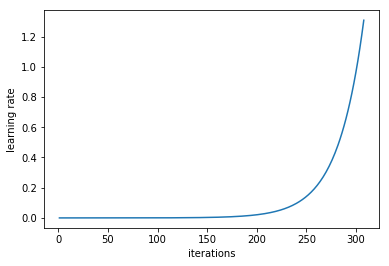

In [34]:
learn.sched.plot_lr()

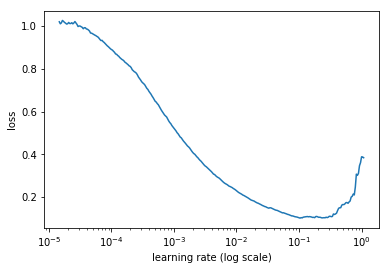

In [35]:
learn.sched.plot()

### The learning schedule
The main idea here is that the learning drops as we get closer and closer to the minimum of the loss function. However,  some sort of a plateau reaches eventually  